# Brazil Sao Paulo sugarcane crop model using Gro API
In this notebook, we walk through the process of building a simple "crop model" using data in Gro. Our crop models use statistical or machine learning algorithms to predict crop yield of a speicific crop and regions. The accompanying Gro web app display for [Sao Paulo Sugarcane](https://app.gro-intelligence.com/displays/wZRlYJQ9B) provides an overview of the data series we will use. The crop model we will create is a very basic  model that uses crop-production-weighted NDVI to forecast  yield.

## Preliminary
Here we use a `CropModel` object as well as some feature transformation functions. We also save the entity ids for the `item` [sugarcane](https://app.gro-intelligence.com/dictionary/items/538), `metric` [processing yield](https://app.gro-intelligence.com/dictionary/metrics/6881050), and for the `region` [Sao Paulo](https://app.gro-intelligence.com/dictionary/regions/10408).  We will use these throughout the notebook to simplify the retrieval, storage and manipulation of data.
In order to download data from our API, you need to set up a GROPI_TOKEN. Instructiosn are in this [wiki page](https://github.com/gro-intelligence/api-client/wiki/Authentication-Tokens#11-using-the-gro-web-application-preferred).

In [1]:
import os
import numpy as np
import pandas as pd
import itertools
import datetime

from api.client.crop_model import CropModel
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.cluster import KMeans

model = CropModel('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])
country_id = model.search_for_entity('regions', "brazil")
region_id = model.search_for_entity('regions', "Sao Paulo")
crop_id =  model.search_for_entity('items', "sugarcane, TRS")


/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


##  Historical Sugar Processing yields
To get data series for the province level sugarcane yield for Sao Paulo, we set the entities (item, metric and region), and get the available data series.  The <em>source</em> for Sao Paulo sugarcane yields is [UNICA](https://app.gro-intelligence.com/dictionary/sources/47).

In [2]:
yield_entities = {}
yield_entities['item_id']  = crop_id
yield_entities['region_id'] = region_id
yield_entities['metric_id'] = model.search_for_entity('metrics', "processing yield mass/mass")
yield_entities['source_id'] = 47 # unica
data_series_list = model.get_data_series(**yield_entities)
print("There are {} data series for {}.".format(len(data_series_list), yield_entities))
for data_series in data_series_list:
    print("source_id {}: {} to {}".format(
        data_series['source_id'], data_series['start_date'], data_series['end_date']))
    model.add_single_data_series(data_series)

Added {u'end_date': u'2019-03-31T00:00:00.000Z', u'source_name': u'UNICA', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Sugarcane, TRS', u'partner_region_name': u'World', u'frequency_id': 9, u'source_id': 47, u'partner_region_id': 0, u'item_id': 7539, u'metric_name': u'Processing Yield (mass/mass)', u'start_date': u'2007-04-01T00:00:00.000Z', u'metric_id': 6881050}
Added {u'end_date': u'2019-07-31T00:00:00.000Z', u'source_name': u'UNICA', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Sugarcane, TRS', u'partner_region_name': u'World', u'frequency_id': 23, u'source_id': 47, u'partner_region_id': 0, u'item_id': 7539, u'metric_name': u'Processing Yield (mass/mass)', u'start_date': u'2008-04-01T00:00:00.000Z', u'metric_id': 6881050}


There are 2 data series for {'item_id': 7539, 'source_id': 47, 'region_id': 10408, 'metric_id': 6881050}.
source_id 47: 2007-04-01T00:00:00.000Z to 2019-03-31T00:00:00.000Z
source_id 47: 2008-04-01T00:00:00.000Z to 2019-07-31T00:00:00.000Z


* As printed above, there are 2 available data series for the Sugar processing yield of Sao Paulo
* Next we retrieve the data frame of these Sugarcane total recoverable sugars (TRS) series and make sure to subset to the metric (Processing Yield (mass/mass)) and region (Sao Paulo) we need

In [3]:

df = model.get_df()
yield_df = df.loc[(df.metric_id == yield_entities['metric_id']) & \
                  (df.region_id == yield_entities['region_id'])]
yield_df.end_date = pd.to_datetime(yield_df.end_date, utc=True)
yield_df['DOY']  = yield_df.end_date.apply(lambda x: int(x.strftime('%j')))
yield_df['Year'] = yield_df.end_date.apply(lambda x: x.year)
yield_df.sort_values(['Year', 'DOY']).tail()



,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,value,DOY,Year
216,2019-05-31 00:00:00+00:00,23,866,1,7539,6881050,10408,2019-05-16T00:00:00.000Z,866,114.160160,151,2019
217,2019-06-15 00:00:00+00:00,23,866,1,7539,6881050,10408,2019-06-01T00:00:00.000Z,866,117.480458,166,2019
218,2019-06-30 00:00:00+00:00,23,866,1,7539,6881050,10408,2019-06-16T00:00:00.000Z,866,122.388328,181,2019
219,2019-07-15 00:00:00+00:00,23,866,1,7539,6881050,10408,2019-07-01T00:00:00.000Z,866,124.565572,196,2019
220,2019-07-31 00:00:00+00:00,23,866,1,7539,6881050,10408,2019-07-16T00:00:00.000Z,866,128.611617,212,2019


* The resulting data frame includes information on the start and end date of the periods corresponding to each processing yield observation, and ids representing the frequency, unit, unit scale, item, metric, and region of our Gro data series. 
**Note**: the unit used here for TRS is kg/ton or kilograms per **US short ton**, not the metric tonnes. 
* The Day of Year and Year columns are derived from the end_date column to help with feature transformation processing

* A scatter plot helps us visualize the progression of the TRS processing yield over time. We suspect that it follows similar seasonal patterns in all years and more recent years might be higher in TRS than years further back. 
* Thus, plot the following figure of TRS versus the day of year and color coded by year.  

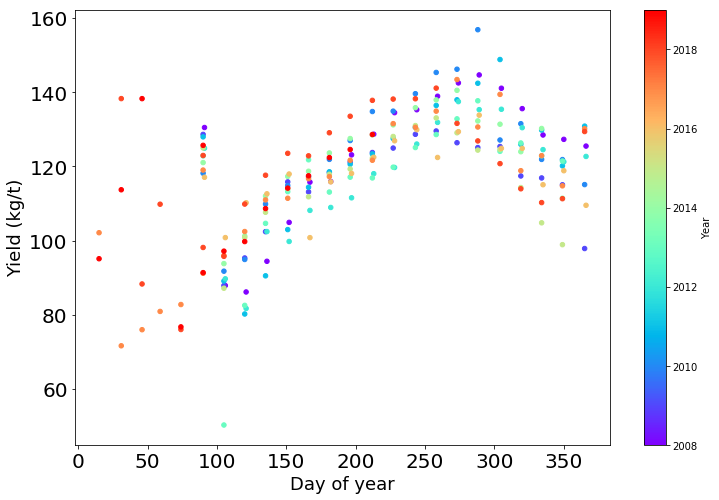

In [4]:
fig, axes = plt.subplots(1, 1)
yield_df[yield_df['value']<300].plot(x='DOY', y='value', kind='scatter',c='Year', cmap='rainbow',
                      ax=axes, figsize=(12,8), fontsize=20, legend=True)
plt.xlabel("Day of year", fontsize=18)
plt.ylabel("Yield (kg/t)", fontsize=18)
plt.show()

* As we can see in this figure above, the sugar processing yield follows a nice increasing pattern from the Day of year (DOY) 100 to about 270 and then goes back down 
* The processing yield between the DOY 350 and 100 appear to show no pattern, and there are only data points for recent years
* For the purpose of this analysis, we thus exclude the study period to between the DOY 100 and 350
* **Note**: you are able to pull data for selected dates. You just need to specify 'start_date' and 'end_date' in the entities dictionary as we used earlier as inputs to the CropModel <i>get_data_series<i> method

In [4]:
df_within_range = yield_df[(yield_df['DOY'] > 100) & (yield_df['DOY'] < 350)]

* In case of making forecast of a next period of TRS, we generate another dataframe of the new dates. For example, here we add a date that is 15 days later than the most recent available TRS period to be predicted.

In [5]:
# date to predict
new_date = df_within_range['end_date'].max() + datetime.timedelta(days=15)
print(new_date.strftime('%Y-%m-%d'))

2019-08-15


In [6]:
# expand the df_within_range with this new date
unknown_df = df_within_range.set_index('end_date').reindex([new_date]).reset_index()
unknown_df['DOY']  = unknown_df.end_date.apply(lambda x: int(x.strftime('%j')))
unknown_df['Year'] = unknown_df.end_date.apply(lambda x: x.year)
df_within_range = pd.concat([df_within_range, unknown_df
                             ], ignore_index=True)


* Next, convert the end_date column to datetime 
* Convert the DOY, Year columns to integers type

In [7]:
df_within_range['end_date'] = pd.to_datetime(df_within_range['end_date'], utc=True)
df_within_range.DOY = df_within_range.DOY.astype(int)
df_within_range.Year = df_within_range.Year.astype(int)
df_within_range.rename(columns={'value': 'TRS'}, inplace=True)
df_within_range.tail()

,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,TRS,DOY,Year
188,2019-06-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-06-01T00:00:00.000Z,866.0,117.480458,166,2019
189,2019-06-30 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-06-16T00:00:00.000Z,866.0,122.388328,181,2019
190,2019-07-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-01T00:00:00.000Z,866.0,124.565572,196,2019
191,2019-07-31 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-16T00:00:00.000Z,866.0,128.611617,212,2019
192,2019-08-15 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227,2019


## NDVI of Sao Paulo
The main signal we will use to model crop yields is [NDVI](https://app.gro-intelligence.com/dictionary/items/321), which represents vegetation biomass per pixel, and thus is a good physical proxy for yield (production mass per unit of area).

First we load the historical data for province level NDVI.  Here, there  are actually two data series for each region, one with `8-day` and one with `16-day` periods. We choose to use the series with 8-day (frequency_id = 3).

In [8]:
entities = {}
entities['item_id'] =  model.search_for_entity('items', "Vegetation NDVI")
entities['metric_id'] = model.search_for_entity('metrics', "Vegetation Indices index")
entities['frequency_id'] = 3


entities['region_id'] = region_id
for data_series in model.get_data_series(**entities):
    model.add_single_data_series(data_series)

Added {u'end_date': u'2019-08-12T00:00:00.000Z', u'source_name': u'GIMMS MODIS NDVI', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Vegetation (NDVI)', u'partner_region_name': u'World', u'frequency_id': 3, u'source_id': 3, u'partner_region_id': 0, u'item_id': 321, u'metric_name': u'Vegetation Indices', u'start_date': u'2000-02-18T00:00:00.000Z', u'metric_id': 70029}


In [9]:
df = model.get_df()
raw_ndvi = df[(df['item_id'] == entities['item_id']) & (df['metric_id']==entities['metric_id'])]
raw_ndvi.head()


,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,reporting_date,start_date,unit_id,value
0,2000-02-25T00:00:00.000Z,3,189,1,321,70029,10408,None,2000-02-18T00:00:00.000Z,189,0.762697
1,2000-03-04T00:00:00.000Z,3,189,1,321,70029,10408,None,2000-02-26T00:00:00.000Z,189,0.695848
2,2000-03-12T00:00:00.000Z,3,189,1,321,70029,10408,None,2000-03-05T00:00:00.000Z,189,0.691231
3,2000-03-20T00:00:00.000Z,3,189,1,321,70029,10408,None,2000-03-13T00:00:00.000Z,189,0.687999
4,2000-03-28T00:00:00.000Z,3,189,1,321,70029,10408,None,2000-03-21T00:00:00.000Z,189,0.712319


* A quick way to summarize the statistics of this NDVI dataframe is to use the *describe()* method
* As shown in the table below, there are 889 data points and the mean NDVI value is 0.63 with a standard deviation of 0.079 min of 0.386 and a max of 0.76

In [10]:
raw_ndvi.describe()

,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,unit_id,value
count,889.0,889.0,889.0,889.0,889.0,889.0,889.0,889.000000
mean,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.630137
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078908
min,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.386523
25%,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.568150
50%,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.649964
75%,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.698267
max,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.762697


* The start and end dates of individual NDVI periods do not match with that of the Sugar processing yield periods because NDVI have 8-day periods while the TRS series has 15-day periods
* In order to synchronize those two data series, we shall transform the NDVI data to a daily time step first and then pick the NDVI value that corresponds to the sugar processing yield data periods' end dates

In [11]:
# transform the 8-day data into a daily dataframe
date_index = 'end_date'
startday = 100
endday = 350
region_index='region_id'
feature = 'value'
raw_ndvi[date_index] = pd.to_datetime(raw_ndvi[date_index], utc=True)
min_date = raw_ndvi[date_index].min()
max_date = pd.to_datetime("{}-{}".format(raw_ndvi[date_index].max().year, endday), 
                          format='%Y-%j', utc=True)
date_range = pd.date_range(min_date, max_date, freq='D', name=date_index)
raw_ndvi_pivot = raw_ndvi.pivot_table(index=date_index, columns=region_index, values=feature)

raw_ndvi_filled = raw_ndvi_pivot.reset_index().set_index(date_index).reindex(
    date_range).asfreq('D').interpolate(
    method='linear',limit_direction='forward', axis=0).stack(   
    region_index).reset_index(name=feature)
raw_ndvi_filled.describe()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,region_id,value
count,7235.0,7235.000000
mean,10408.0,0.628844
std,0.0,0.078118
min,10408.0,0.386523
25%,10408.0,0.561407
50%,10408.0,0.645618
75%,10408.0,0.697275
max,10408.0,0.762697


* The data frame printed above shows the result of applying linear interpolation of NDVI from 8-day periods to daily timestep
* Next, subset the NDVI data to our study timeframe between the DOY 100 and 350

In [12]:
# Get the Doy of year (DOY) as well as Year from the date index
raw_ndvi_filled.loc[:, 'doy'] = raw_ndvi_filled[date_index].dt.dayofyear
raw_ndvi_filled.loc[:, 'year'] = raw_ndvi_filled[date_index].dt.year
ndvi_within_range = raw_ndvi_filled[(raw_ndvi_filled['doy'] > 100) & (
    raw_ndvi_filled['doy'] < 350)]


* And then merge together the NDVI data frame with the TRS or sugar processing yield data frame
* keep the NDVI values of the dates that match with the TRS period end dates

In [13]:
ndvi_within_range.rename(columns={'value': 'ndvi'}, inplace=True)
ndvi_df = ndvi_within_range[ndvi_within_range['year'].isin(df_within_range['Year'].unique())]


ndvi_df.loc[:, 'DOY'] = ndvi_df.doy.astype(int)
ndvi_df.loc[:, 'Year'] = ndvi_df.year.astype(int)

ndvi_y = df_within_range[['DOY','Year','TRS']].merge(ndvi_df[['end_date','doy','year', 'ndvi']],
                        left_on=['DOY','Year'], right_on= ['doy','year'], how='left')
ndvi_y.tail()


/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

,DOY,Year,TRS,end_date,doy,year,ndvi
188,166,2019,117.480458,2019-06-15 00:00:00+00:00,166,2019,0.670779
189,181,2019,122.388328,2019-06-30 00:00:00+00:00,181,2019,0.637306
190,196,2019,124.565572,2019-07-15 00:00:00+00:00,196,2019,0.607610
191,212,2019,128.611617,2019-07-31 00:00:00+00:00,212,2019,0.562770
192,227,2019,NaN,2019-08-15 00:00:00+00:00,227,2019,0.558451


* What is the relationship between TRS and NDVI? 
* Are there any different patterns for different seasons of a year?
* The scatter plot between TRS and NDVI color coded by the Day of Year (DOY) answers these questions

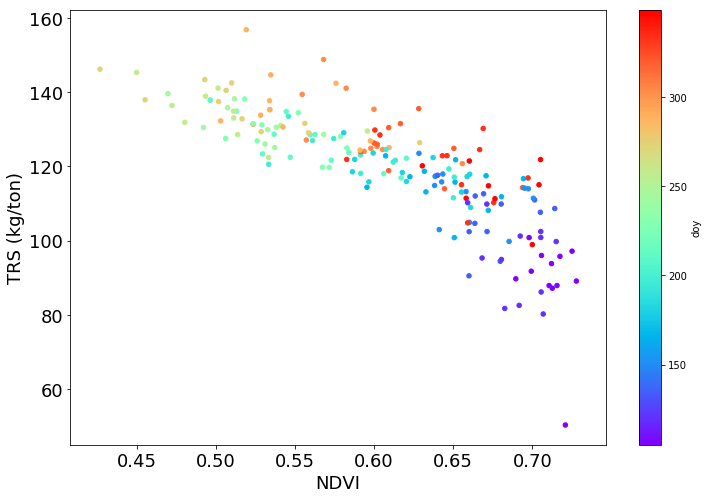

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
        
ndvi_y.plot(x='ndvi', y='TRS', c='doy', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('NDVI', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()

* As shown in this figure above, there is an overall negative relationship between the content of Total Recoverable Sugar (TRS) and the NDVI values
* This negative correlation has greater magnitude (a steeper slope) during earlier DOY than the rest of the year

### Daily FEWS_PET versus Sugar Content
In addition to NDVI, there are various weather condition features that may be able to capture variation in the sugar processing yield. The potential evapotranspiration is one important measurement: [FEWS_PET](https://app.gro-intelligence.com/dictionary/items/5072)

In [14]:
entities = {}
entities['item_id'] =  5072
entities['metric_id'] = 4660031
entities['frequency_id'] = 1 # daily
entities['source_id'] = 44
entities['region_id'] = region_id

for data_series in model.get_data_series(**entities):
    model.add_single_data_series(data_series)


Added {u'end_date': u'2019-08-19T00:00:00.000Z', u'source_name': u'FEWS PET', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Potential evapotranspiration (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 44, u'partner_region_id': 0, u'item_id': 5072, u'metric_name': u'Evapotranspiration Value', u'start_date': u'2008-01-01T00:00:00.000Z', u'metric_id': 4660031}


In [15]:
model.get_df()
raw_pet = model._data_frame[model._data_frame['metric_id'] == 4660031]
raw_pet.tail()


,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,reporting_date,start_date,unit_id,value
4244,2019-08-15T00:00:00.000Z,1,2,1,5072,4660031,10408,NaN,2019-08-15T00:00:00.000Z,2,3.754118
4245,2019-08-16T00:00:00.000Z,1,2,1,5072,4660031,10408,NaN,2019-08-16T00:00:00.000Z,2,3.817201
4246,2019-08-17T00:00:00.000Z,1,2,1,5072,4660031,10408,NaN,2019-08-17T00:00:00.000Z,2,4.458396
4247,2019-08-18T00:00:00.000Z,1,2,1,5072,4660031,10408,NaN,2019-08-18T00:00:00.000Z,2,4.020931
4248,2019-08-19T00:00:00.000Z,1,2,1,5072,4660031,10408,NaN,2019-08-19T00:00:00.000Z,2,2.619811


In [16]:
raw_pet.loc[:, date_index] = pd.to_datetime(raw_pet[date_index], utc=True)

raw_pet.loc[:, 'doy'] = raw_pet[date_index].dt.dayofyear
raw_pet.loc[:, 'year'] = raw_pet[date_index].dt.year


* Since PET is available at daily time step, we could directly aggregate it to match with the same periods of the Sugar processing yield or TRS dataset
* First merge the DOY information from the TRS dataset and then aggregate PET to those periods

In [17]:
pet_agg = raw_pet[['doy','year', 'value']].merge(df_within_range[['DOY','Year','TRS']],
                        right_on=['DOY','Year'], left_on= ['doy','year'], how='left')
pet_agg = pet_agg[pet_agg['year'] >= 2008][pet_agg['doy']>=100][pet_agg['doy']<=350]
pet_grouped = pet_agg.fillna(method='bfill').groupby(['year','DOY']).mean().reset_index()

pet_y = df_within_range.merge(pet_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
pet_y.sort_values(['Year','DOY']).tail()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,TRS,DOY,Year,value,year
188,2019-06-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-06-01T00:00:00.000Z,866.0,117.480458,166,2019,2.442303,2019
189,2019-06-30 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-06-16T00:00:00.000Z,866.0,122.388328,181,2019,2.680475,2019
190,2019-07-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-01T00:00:00.000Z,866.0,124.565572,196,2019,2.379085,2019
191,2019-07-31 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-16T00:00:00.000Z,866.0,128.611617,212,2019,2.848207,2019
192,2019-08-15 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227,2019,3.342540,2019


* Next we use a color coded scatter plot to show the relationship between TRS and PET

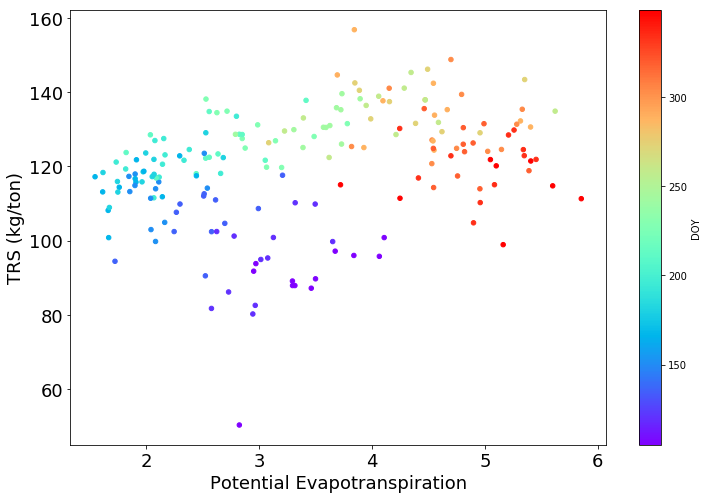

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
        
pet_y.plot(x='value', y='TRS', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('Potential Evapotranspiration', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()


* There appears to be a positive relationship between TRS and PET for the DOY between 170 to 260, 
* While the rest of the days of a year appeared to show a much weaker relationship

### Daily TRMM precipitation versus Sugar Content
The daily precipitation is another weather variable that might be important to the sugar processing yield.
[TRMM](https://app.gro-intelligence.com/dictionary/sources/35)
[Precipitation](https://app.gro-intelligence.com/dictionary/items/10081)

In [18]:
entities = {}
entities['item_id'] =  10081
entities['metric_id'] = 2100031
entities['frequency_id'] = 1 # daily
entities['source_id'] = 35
entities['region_id'] = region_id

for data_series in model.get_data_series(**entities):
    if data_series['region_id']==region_id:
        model.add_single_data_series(data_series)


Added {u'end_date': u'2019-08-20T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}


In [19]:
model.get_df()
raw_trmm = model._data_frame[(model._data_frame['metric_id'] == 2100031) & (
    model._data_frame['item_id'] == 2039)]
raw_trmm[date_index] = pd.to_datetime(raw_trmm[date_index], utc=True)

raw_trmm.loc[:, 'doy'] = raw_trmm[date_index].dt.dayofyear
raw_trmm.loc[:, 'year'] = raw_trmm[date_index].dt.year

raw_trmm.describe()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,unit_id,value,doy,year
count,7112.0,7112.0,7112.0,7112.0,7112.0,7112.0,7112.0,7112.000000,7112.000000,7112.000000
mean,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,3.897305,182.245922,2009.401434
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.116831,104.604270,5.630153
min,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,0.000000,1.000000,2000.000000
25%,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,0.042033,92.000000,2005.000000
50%,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,0.790988,181.000000,2009.000000
75%,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,5.648062,272.000000,2014.000000
max,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,54.555632,366.000000,2019.000000


* Similar to PET, TRMM is also a data source at the daily timestep, so we follow a similar procedure to aggregate it to the same periods as the TRS dataset

In [20]:
trmm_agg = raw_trmm[['doy','year', 'value']].merge(df_within_range[['DOY','Year','TRS']],
                        right_on=['DOY','Year'], left_on= ['doy','year'], how='left')
trmm_agg = trmm_agg[trmm_agg['year'] >= 2008][trmm_agg['doy']>=100][trmm_agg['doy']<=350]


trmm_grouped = trmm_agg.fillna(method='bfill').groupby(['DOY','year']).mean().reset_index()

trmm_y = df_within_range.merge(trmm_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
trmm_y.tail()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,TRS,DOY,Year,value,year
188,2019-06-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-06-01T00:00:00.000Z,866.0,117.480458,166,2019,1.293619,2019
189,2019-06-30 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-06-16T00:00:00.000Z,866.0,122.388328,181,2019,0.155427,2019
190,2019-07-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-01T00:00:00.000Z,866.0,124.565572,196,2019,1.840031,2019
191,2019-07-31 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-16T00:00:00.000Z,866.0,128.611617,212,2019,0.394535,2019
192,2019-08-15 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227,2019,0.521046,2019


* Next, we use a scatter plot to show the relationship between TRS and TRMM precipitation

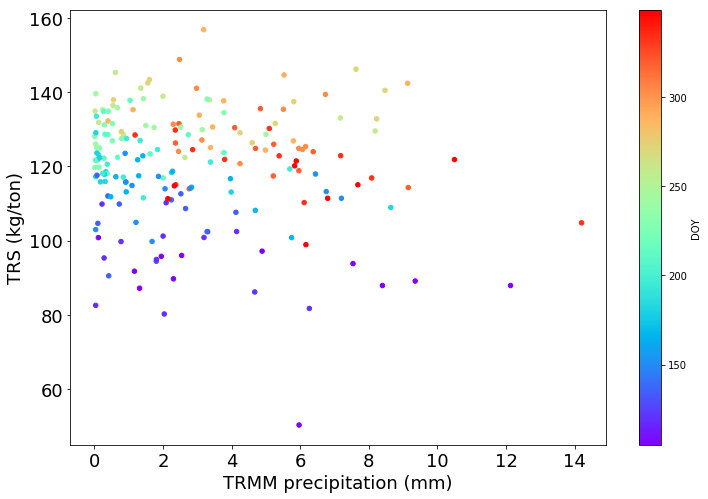

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
        
trmm_y.plot(x='value', y='TRS', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('TRMM precipitation (mm)', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()


* As shown in the scatter plot above, there appears to be a mild negative relationship between TRS and TRMM precipitation post the DOY 300 and prior to the DOY 200

### Daily LST temperature versus Sugar Content
The Land Surface Temperature ([LST](https://app.gro-intelligence.com/dictionary/sources/26)) is a daily timestep temperature data source.


In [21]:
model = CropModel('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])
entities = {}
entities['item_id'] =  model.search_for_entity('items', "Land temperature")
entities['metric_id'] = model.search_for_entity('metrics', "Temperature")
entities['region_id'] = region_id
entities['frequency_id']= 1

model = CropModel('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])

for data_series in model.get_data_series(**entities):
    if data_series['region_id'] == region_id :
        model.add_single_data_series(data_series)


Added {u'end_date': u'2019-08-18T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}


* Again, we aggregate the LST temperature data to the same periods as the TRS sugar processing yield data

In [22]:
model.get_df()
raw_lst = model._data_frame[model._data_frame['metric_id'] == entities['metric_id']]
print(raw_lst.end_date.unique())
raw_lst.loc[:, date_index] = pd.to_datetime(raw_lst[date_index], utc=True)

raw_lst.loc[:, 'doy'] = raw_lst[date_index].dt.dayofyear
raw_lst.loc[:, 'year'] = raw_lst[date_index].dt.year

raw_lst.describe()

[u'2000-02-25T00:00:00.000Z' u'2000-02-26T00:00:00.000Z'
 u'2000-02-27T00:00:00.000Z' ... u'2019-08-16T00:00:00.000Z'
 u'2019-08-17T00:00:00.000Z' u'2019-08-18T00:00:00.000Z']


,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,unit_id,value,doy,year
count,6972.0,6972.0,6972.0,6972.0,6972.0,6972.0,6972.0,6920.000000,6972.000000,6972.000000
mean,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,26.811989,182.203672,2009.422978
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.355859,104.512793,5.616129
min,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,11.082408,1.000000,2000.000000
25%,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,23.954683,93.000000,2005.000000
50%,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,26.783905,182.000000,2009.000000
75%,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,29.785467,272.000000,2014.000000
max,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,42.230718,366.000000,2019.000000


In [23]:
lst_agg = raw_lst[['end_date','value', 'doy','year']].merge(df_within_range[['end_date','DOY']],
                        on='end_date' , how='left').drop_duplicates()
lst_agg = lst_agg[lst_agg['year'] >= 2008][lst_agg['doy']>=100][lst_agg['doy']<=350]


lst_grouped = lst_agg.fillna(method='bfill').groupby(['DOY','year']).mean().reset_index()

lst_y = df_within_range.merge(lst_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
lst_y.tail()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,TRS,DOY,Year,value,year
188,2019-06-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-06-01T00:00:00.000Z,866.0,117.480458,166,2019,23.721730,2019
189,2019-06-30 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-06-16T00:00:00.000Z,866.0,122.388328,181,2019,25.639388,2019
190,2019-07-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-01T00:00:00.000Z,866.0,124.565572,196,2019,22.390140,2019
191,2019-07-31 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-07-16T00:00:00.000Z,866.0,128.611617,212,2019,23.372214,2019
192,2019-08-15 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227,2019,25.983064,2019


* Again, we plot a scatter plot of TRS versus LST to visualize the relationship between total recoverable sugar and the land surface temperature 

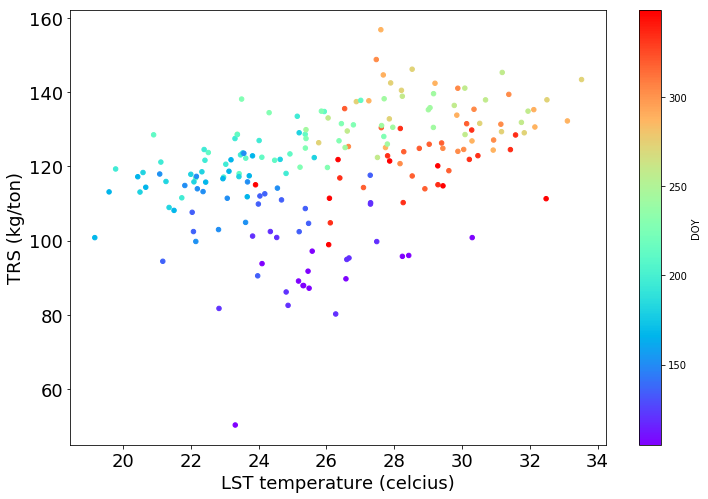

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
        
lst_y.plot(x='value', y='TRS', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('LST temperature (celcius)', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()


* The LST appears to be positively correlated with the TRS, especially for the DOY between 170 and 270

### Merge together the varaibles and assess relationships among them

In [24]:
pet_y.rename(columns={'value': 'pet'}, inplace=True)
trmm_y.rename(columns={'value': 'trmm'}, inplace=True)
lst_y.rename(columns={'value': 'lst'}, inplace=True)
pet_y.DOY = pet_y.DOY.astype(int)
trmm_y.DOY = trmm_y.DOY.astype(int)
lst_y.DOY = lst_y.DOY.astype(int)
df_tog=ndvi_df.merge(pet_y[['pet', 'DOY','year', 'TRS']], on=['DOY', 'year'], how='inner'
                    ).merge(trmm_y[['trmm', 'DOY','year']], on=['DOY', 'year'], how='left'
                    ).merge(lst_y[['lst', 'DOY','year']], on=['DOY', 'year'], how='left'
                    )

df_tog.sort_values(['year','DOY'], ascending=True).tail()

,end_date,region_id,ndvi,doy,year,DOY,Year,pet,TRS,trmm,lst
188,2019-06-15 00:00:00+00:00,10408,0.670779,166,2019,166,2019,2.442303,117.480458,1.293619,23.721730
189,2019-06-30 00:00:00+00:00,10408,0.637306,181,2019,181,2019,2.680475,122.388328,0.155427,25.639388
190,2019-07-15 00:00:00+00:00,10408,0.607610,196,2019,196,2019,2.379085,124.565572,1.840031,22.390140
191,2019-07-31 00:00:00+00:00,10408,0.562770,212,2019,212,2019,2.848207,128.611617,0.394535,23.372214
192,2019-08-15 00:00:00+00:00,10408,0.558451,227,2019,227,2019,3.342540,NaN,0.521046,25.983064


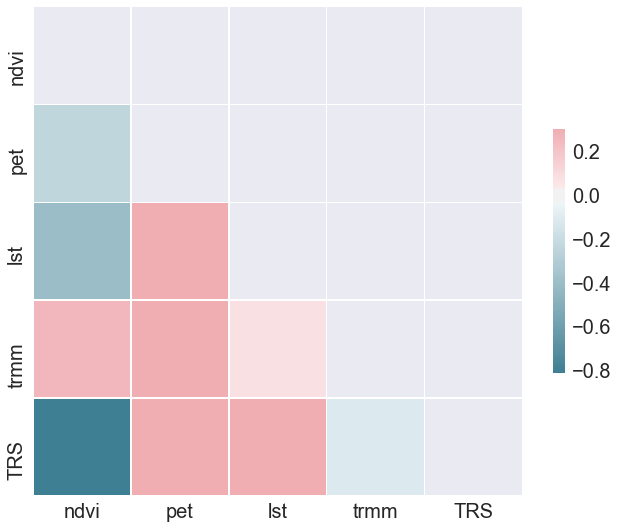

In [39]:

corr = df_tog[['ndvi','pet','lst', 'trmm','TRS']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=2) 
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

* Intuitively, NDVI is positively correlated with precipitation and negatively correlated with LST and PET.
* Also, PET, as a modeled product with temperature and precipitation as major inputs, is positively correlated with LST and TRMM.
* Temperature appears to be mildly positively correlated with precipitation, which is because the dry season corresponds to the winter or colder season in the southern atmosphere, or Sao Paulo here.

### Cluster the points to find a refined cutting point of the Day of Year of periods
* The previous scatter plots between TRS and weather variables manifested three clusters of DOY periods
* Because of such differing responses of TRS to weather conditions at different time of the year, it would be more accurately to model those three periods separately
* First of all, we need to clearly define the boundaries of those three clusters, and KMeans is a simple clustering method to do so

In [25]:

X = np.array(df_tog[['ndvi','pet','lst', 'trmm','TRS','DOY']].dropna())
f_names = ['ndvi','pet','lst', 'trmm','TRS','DOY']
kmeans = KMeans(3)
kmeans.fit(X)
# save new clusters for chart
y_km = kmeans.fit_predict(X)

* Add a variable name `group` to record the KMeans clustering result, as printed below

In [26]:
data_decision = pd.DataFrame(X)
data_decision.columns = f_names
data_decision['group'] = y_km
data_decision.head()

,ndvi,pet,lst,trmm,TRS,DOY,group
0,0.715580,3.294363,25.309613,12.132686,87.897155,106.0,1
1,0.705581,2.727573,24.810822,4.674732,86.164431,121.0,1
2,0.679714,1.720972,21.170560,1.804685,94.437959,136.0,1
3,0.660312,2.161575,23.613483,1.212690,104.925017,152.0,1
4,0.651189,1.906621,22.436543,0.919376,115.774950,167.0,1


In [27]:
print(data_decision.groupby('group').min())
data_decision.groupby('group').max()

           ndvi       pet        lst      trmm         TRS    DOY
group                                                            
0      0.426879  3.082981  23.907087  0.399399   98.919452  273.0
1      0.595553  1.544240  19.164008  0.038529   50.303408  105.0
2      0.450034  1.614573  19.779119  0.012298  108.943847  181.0


,ndvi,pet,lst,trmm,TRS,DOY
group,,,,,,
0,0.705202,5.853101,33.526674,14.202166,156.861358,349.0
1,0.727826,4.106493,30.300360,12.132686,123.540453,167.0
2,0.661019,5.621423,31.948077,8.642510,145.340109,259.0


We see that the three clusters of periods are the following
* period DOY 100-182
* period DOY 196-259
* period DOY 273-350

Cutoff DOY between periods: 190, 265.
Next, we visualize the relationship between all combinations of variables colored by the clustering groups

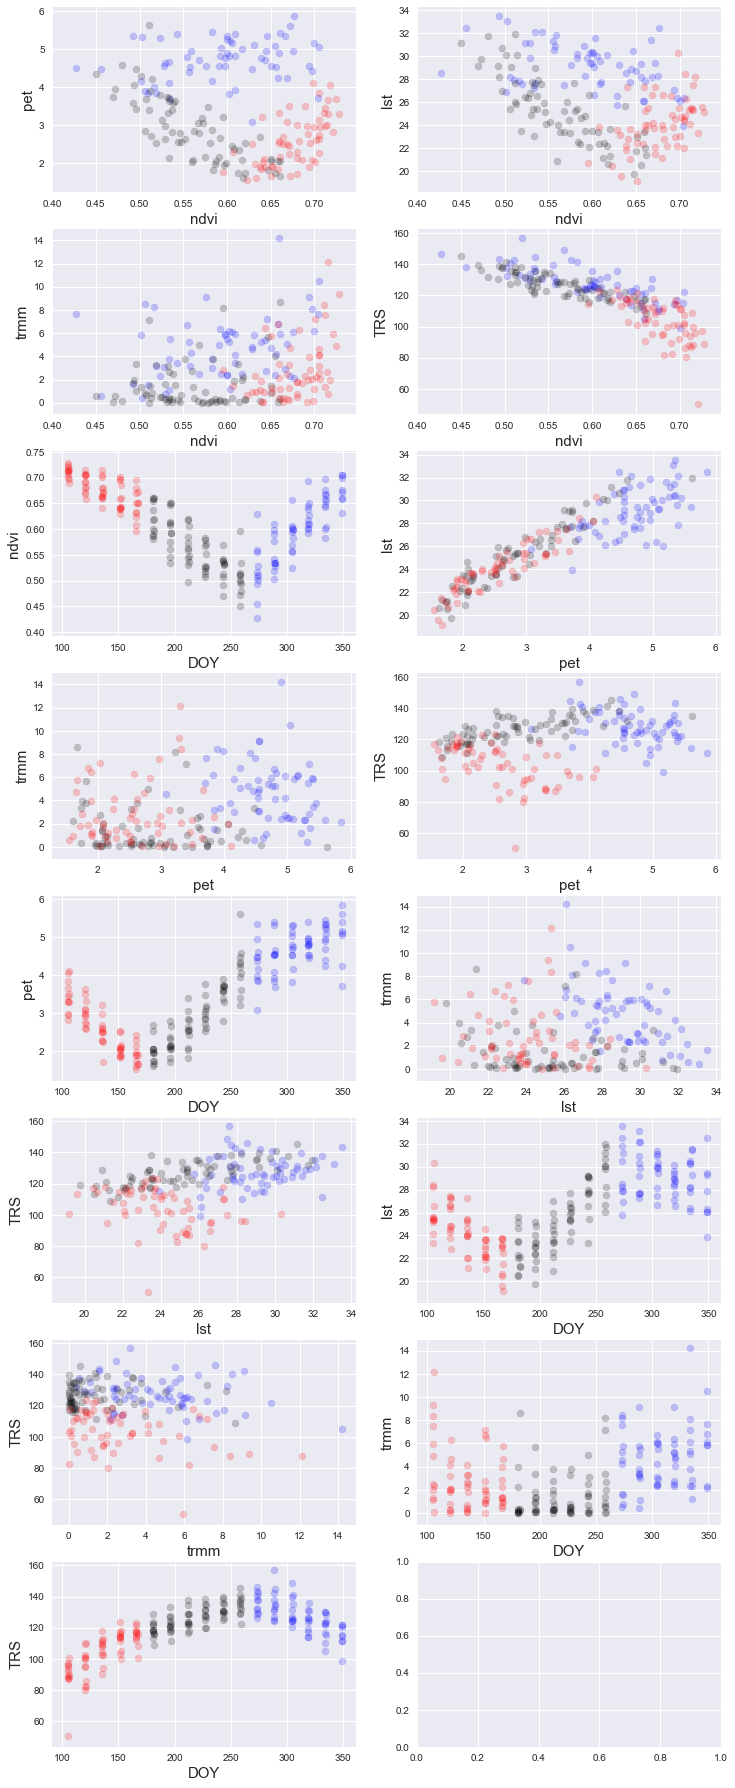

In [43]:
combos = [l for l in itertools.combinations(f_names,2)]

n_vars = len(combos)
n_rows = n_vars//2 + n_vars%2
sns.set(font_scale=1) 
alpha = 0.2
fig, axes = plt.subplots(n_rows, 2, figsize=(12, n_rows*4))
for i in range(n_vars):
    ax = axes[i//2, i % 2]
    var_1, var2 = combos[i]
    if 'DOY' in combos[i]:
        var_1 = 'DOY'
        var2 = (set(combos[i]) - {'DOY'}).pop()
    ax.scatter(X[y_km ==0,f_names.index(var_1)], X[y_km == 0,f_names.index(var2)], s=50, c='blue', alpha = alpha)
    ax.scatter(X[y_km ==1,f_names.index(var_1)], X[y_km == 1,f_names.index(var2)], s=50, c='black', alpha = alpha)
    ax.scatter(X[y_km ==2,f_names.index(var_1)], X[y_km == 2,f_names.index(var2)], s=50, c='red', alpha = alpha)
    ax.set_xlabel(var_1, fontsize=15)
    ax.set_ylabel(var2, fontsize=15)

* The red color is the earliest group, the blue color shows the middle group and the black color represents the latest group above.
* The seansonality is also clearly portrayed by the Temperature, precipitation and PET from the DOY 100 to 350

### Fit a multivariate linear regression for each Sub-harvesting-season
* There are many models we could choose to predict TRS
* A multivariate linear regression is a most simple method
    -- easy to interpret 
    -- fast to run
* The statsmodels package provides detailed regression statistics
    -- we use the OLS (ordinary least squares) regressor here

In [28]:
for name in ['lst','pet','trmm','ndvi','TRS']:
    df_tog[name] = df_tog[name].astype(float)

In [29]:
new_dat_list = []    
model_list = []
ranges = [(100, 190), (190, 265), (265,350)]
for L, R in ranges:
    sub_dat = df_tog[df_tog['DOY'] > L][df_tog['DOY'] < R].dropna()
    sub_dat['intercept'] = 1.
    X = sub_dat[['lst','pet','trmm','ndvi','intercept']]
    Y = sub_dat['TRS']
    # with statsmodels
    model = sm.OLS(Y, X).fit()
    sub_dat['pred'] = model.predict(X) 
    new_dat_list.append(sub_dat)
    model_list.append(model)
    print("TRS periods with DOY {} to {}".format(L, R))
    print(model.summary())
with_pred = pd.concat(new_dat_list, axis=0)#.drop_duplicates()


TRS periods with DOY 100 to 190
                            OLS Regression Results                            
Dep. Variable:                    TRS   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     20.64
Date:                Wed, 21 Aug 2019   Prob (F-statistic):           4.06e-11
Time:                        13:50:44   Log-Likelihood:                -260.64
No. Observations:                  72   AIC:                             531.3
Df Residuals:                      67   BIC:                             542.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lst            3.522

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


* The middle period linear regression model (DOY 196-259) appeared to have the best performance in terms of the variance explained
* The following scatter plot shows the predicted versus actual yield along the 1-1 line

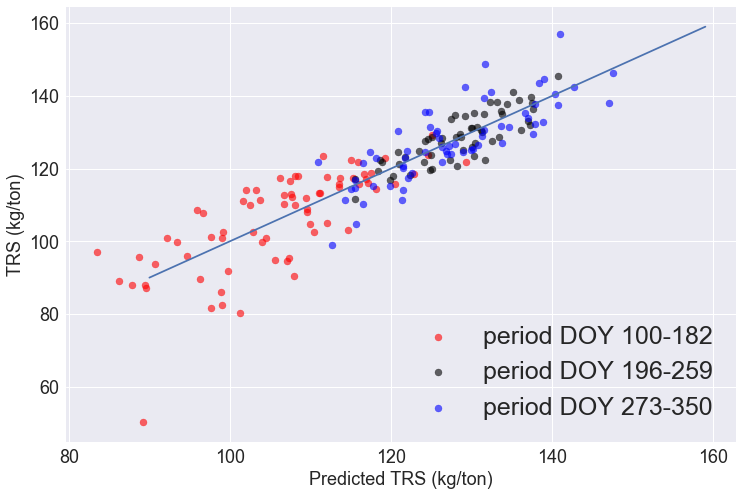

In [55]:
sns.set(font_scale=2.5) 
fig, ax = plt.subplots(figsize=(12,8))
with_pred[with_pred['DOY'] < 190].plot(x='pred', y='TRS', fontsize=18, kind='scatter', 
                                                              legend=False, ax=ax, s=50, c='red', alpha=0.6)
with_pred[(with_pred['DOY'] > 190) & (with_pred['DOY'] < 265)].plot(x='pred', y='TRS', fontsize=18, kind='scatter', 
                                                              legend=False, ax=ax, s=50, c='black', alpha=0.6)
with_pred[with_pred['DOY'] >270].plot(x='pred', y='TRS', fontsize=18, kind='scatter', 
                                                              legend=False, ax=ax, s=50, c='blue', alpha=0.6)
plt.legend(['period DOY 100-182',
'period DOY 196-259',
'period DOY 273-350'])
ax.plot(range(90,160), range(90,160))
plt.xlabel('Predicted TRS (kg/ton)', fontsize=18)
plt.ylabel('TRS (kg/ton)', fontsize=18)
plt.show()

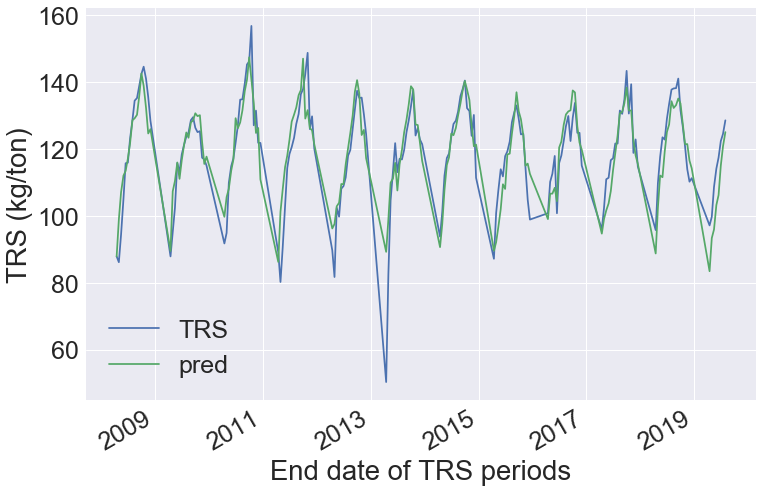

In [56]:
with_pred.set_index('end_date')

fig, ax = plt.subplots(figsize=(12,8))
with_pred.plot(x='end_date', y='TRS', ax=ax)
with_pred.plot(x='end_date', y='pred', ax=ax)
plt.xlabel('End date of TRS periods')
plt.ylabel('TRS (kg/ton)')
plt.show()

* Our model estimated TRS of all periods combined matched well with the Actual, especially during the peak TRS value periods

### Making predictions with the Model coefficients when a most recent period of TRS value was assumed to be available

In [45]:
# the cluster of TRS periods DOY 100-182
coef_early = model_list[0].params
coef_early.pop('intercept')

# the cluster of DOY periods 196-259
coef_mid = model_list[1].params
coef_mid.pop('intercept')

# the cluster of TRS periods DOY 273-350
coef_late = model_list[2].params
coef_late.pop('intercept')

218.46854269464234

* The coefficients of the linear regression models of different periods are stored above
* Then subset the dataframe to the last 5 TRS periods, including the period to be predicted
* Compute the differences in variables between periods

In [46]:
recent_df = df_tog.sort_values(['year','DOY']).tail()
var_list = coef_mid.index.values
recent_diff = recent_df[var_list].diff()


* Calculate the predicted change in TRS from a previous period by making a dot product of the ['lst','pet','trmm','ndvi'] differences and the coefficients
* Since we are in the middle period already, use the middle period parameters

In [47]:

recent_df['TRS_diff'] = np.dot(recent_diff.values, np.array(coef_mid).reshape(4, -1)).reshape(1,-1)[0]


* Finally, add the predicted change in TRS or *"TRS_diff"* to the previous periods to get the *"pred_TRS"*

In [48]:
recent_df['pred_TRS'] = [np.nan] + list(recent_df['TRS_diff'].values[1:] + recent_df['TRS'].values[:-1])
recent_df

,end_date,region_id,ndvi,doy,year,DOY,Year,pet,TRS,trmm,lst,TRS_diff,pred_TRS
188,2019-06-15 00:00:00+00:00,10408,0.670779,166,2019,166,2019,2.442303,117.480458,1.293619,23.721730,NaN,NaN
189,2019-06-30 00:00:00+00:00,10408,0.637306,181,2019,181,2019,2.680475,122.388328,0.155427,25.639388,3.576147,121.056605
190,2019-07-15 00:00:00+00:00,10408,0.607610,196,2019,196,2019,2.379085,124.565572,1.840031,22.390140,3.399746,125.788074
191,2019-07-31 00:00:00+00:00,10408,0.562770,212,2019,212,2019,2.848207,128.611617,0.394535,23.372214,4.257245,128.822818
192,2019-08-15 00:00:00+00:00,10408,0.558451,227,2019,227,2019,3.342540,NaN,0.521046,25.983064,1.549629,130.161247


In [50]:
# Calculate the Mean Squared Error as an evaluation
recent_df['pred_TRS'].subtract(recent_df['TRS']).abs().mean()

0.9218085147755156

### Conclusion
* You can use this model to predict future periods of TRS where we have available Temperature (LST), Precipitation (TRMM), Potential Evapotranspiration (PET) and NDVI data.
* The example in this notebook predicted the TRS period with end_date "2019-08-15" to has 130.16 kg/ton (US short ton) of Total Recoverable Sugar content. The predictions using the same method for 3 previous periods got an average Mean Squared Error of 0.9 kg/ton 